In [1]:
import pandas as pd
import numpy as np
import pymc as pm
import pymc.sampling.jax as pmjax
import matplotlib.pyplot as plt
from utils import compute_points
from tqdm.auto import tqdm

/home/onorevole/miniconda3/envs/pymc_5/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Inspect data and choose prior

Mean:  72.10714285714286
Standard Deviation:  7.436345520070834


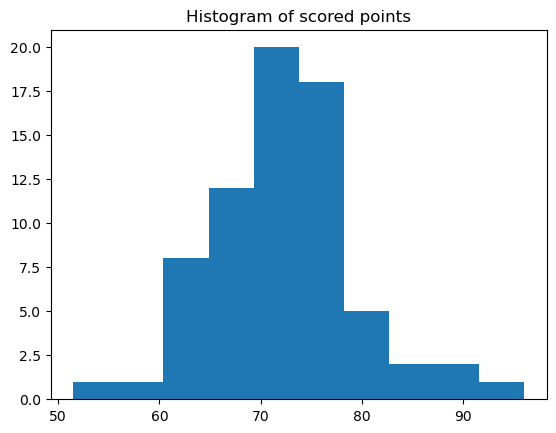

In [2]:
#read scores
df = pd.read_csv("./data/Punti.csv")

#save all the obtained scores in a single array
teams = df["name"].unique()
scores = np.empty(0)
for team in teams:
    df_team = df.loc[df["name"] == team]
    score_team = df_team.values[0][2:-1].astype("float")
    score_team = score_team[~np.isnan(score_team)]
    scores = np.concatenate((scores, score_team))

#display the array as histogram
plt.hist(scores)
plt.title("Histogram of scored points")
mean = np.mean(scores)
sd = np.std(scores)
print("Mean: ", mean)
print("Standard Deviation: ", sd)

#Normal with seams like a fair assumption to start with.
#However, for the individual teams it should be possible to be
#left or right skewed


Inspect the score distibution of every individual 

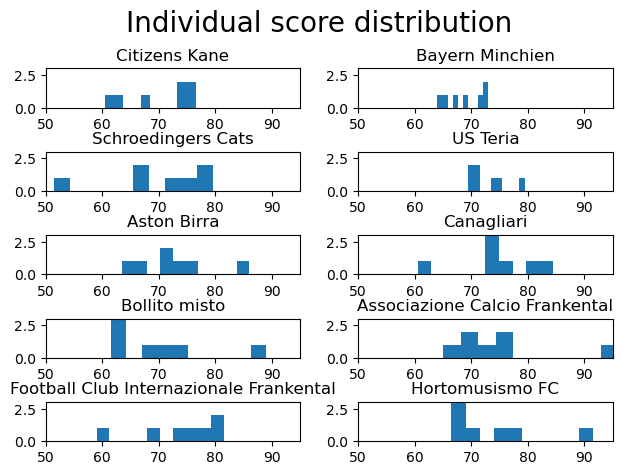

In [3]:
fig, ax = plt.subplots(5,2)
fig.tight_layout(rect=(0,0,1,0.9))
fig.suptitle("Individual score distribution", fontsize = 20)

for i,team in enumerate(teams):
    
    df_team = df.loc[df["name"] == team]
    score_team = df_team.values[0][2:-1].astype("float")
    score_team = score_team[~np.isnan(score_team)]
    
    ax[i%5,i%2].set_title(team)
    ax[i%5,i%2].set_xlim(50,95)
    ax[i%5,i%2].set_ylim(0,3)
    ax[i%5,i%2].hist(score_team)

    

Define the hierarchical model

In [4]:
with pm.Model() as model:

    ## define the hyperprior
    lambda_hp = pm.Uniform("lambda_hp", lower=0, upper=1)

    for team in teams:
        
        #extract the data for the team
        df_team = df.loc[df["name"] == team]
        score_team = df_team.values[0][2:-1].astype("float")
        score_team = score_team[~np.isnan(score_team)]
        score_team = score_team[:,None]        
        #set the prior
        alpha = pm.Deterministic(f"alpha_{team}",
                                 1+pm.Exponential(f"Exp_alpha_{team}", lambda_hp))
        beta = pm.Deterministic(f"beta_{team}",
                                1+pm.Exponential(f"Exp_beta_{team}", lambda_hp))
        
        #normalize the observed score
        score_normalized = (score_team - mean)/(sd**2)+0.5
        #model the score        
        normalized_score = pm.Beta(f"normalized_score_{team}", alpha=alpha, beta=beta, 
                observed=score_normalized)
        #TODO make sure normalized score is always between 0 and 1
        
        #reassemble the actual score for later sampling
        score = pm.Deterministic(f"score_{team}", mean + (sd**2)*(
                                normalized_score-0.5))
    

Prior predictive checks

Sampling: [Exp_alpha_Citizens Kane, Exp_beta_Citizens Kane, lambda_hp, normalized_score_Citizens Kane]


Text(0.5, 1.0, 'Prior check')

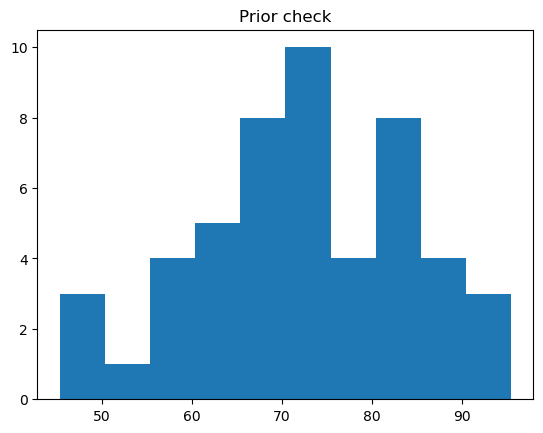

In [5]:
i_data = pm.sample_prior_predictive(samples=50, model=model,
                                    var_names=["score_Citizens Kane"])

plt.hist(i_data["prior"]["score_Citizens Kane"].values[0,:,0])
plt.title("Prior check")

#note that the prior should be independent on the chosen team
#prior seems reasonable

Sample

In [6]:
with model:
    #i_data = pm.sample()
    trace = pmjax.sample_blackjax_nuts(draws=1000, tune=1000,
                                            chains=4, target_accept=0.8)

Compiling...


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Compilation time =  0:00:11.046842
Sampling...
Sampling time =  0:00:38.528412
Transforming variables...
Transformation time =  0:00:01.610955


Inspect the posterior

Sampling: [normalized_score_Citizens Kane]


Sampling: [normalized_score_US Teria]


Sampling: [normalized_score_Aston Birra]


Sampling: [normalized_score_Associazione Calcio Frankental]


Sampling: [normalized_score_Football Club Internazionale Frankental]


Sampling: [normalized_score_Bayern Minchien]


Sampling: [normalized_score_Schroedingers Cats]


Sampling: [normalized_score_Canagliari]


Sampling: [normalized_score_Bollito misto]


Sampling: [normalized_score_Hortomusismo FC]


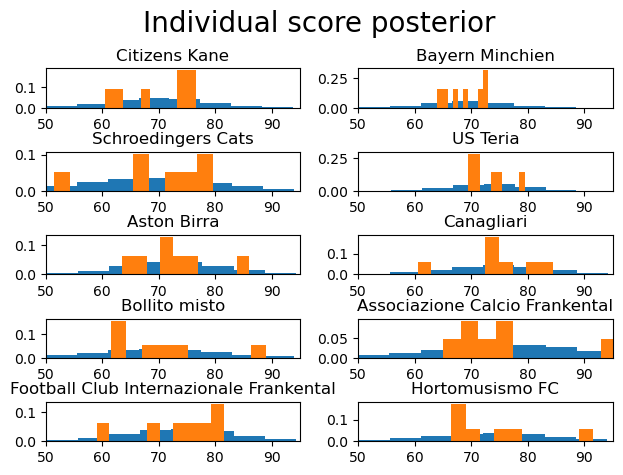

In [7]:
fig, ax = plt.subplots(5,2)
fig.tight_layout(rect=(0,0,1,0.9))
fig.suptitle("Individual score posterior", fontsize = 20)

for i,team in enumerate(teams):
    
    posterior = pm.sample_posterior_predictive(trace,model,[f"score_{team}"])
    posterior = posterior.posterior_predictive[f"score_{team}"].values.ravel()
    
    df_team = df.loc[df["name"] == team]
    score_team = df_team.values[0][2:-1].astype("float")
    score_team = score_team[~np.isnan(score_team)]
    
    ax[i%5,i%2].set_title(team)
    ax[i%5,i%2].set_xlim(50,95)
    ax[i%5,i%2].hist(posterior, density=True)
    ax[i%5,i%2].hist(score_team,density=True)

Simulate the remaining part of the league

In [8]:
num_league_simulation = 10000
last_played_match_day = 7
total_match_day = 36
current_standing = {'Citizens Kane': 9,
                    'US Teria': 10,
                    'Aston Birra': 9,
                    'Associazione Calcio Frankental': 14,
                    'Football Club Internazionale Frankental': 10,
                    'Bayern Minchien': 3,
                    'Schroedingers Cats': 14,
                    'Canagliari': 12,
                    'Bollito misto': 5,
                    'Hortomusismo FC': 12}

#########################

#sample from the posterior
team_scores = {}
for team in teams:
    posterior = pm.sample_posterior_predictive(trace,model,[f"score_{team}"])
    posterior = posterior.posterior_predictive[f"score_{team}"].values.ravel()
    team_scores[team] = posterior




Sampling: [normalized_score_Citizens Kane]


Sampling: [normalized_score_US Teria]


Sampling: [normalized_score_Aston Birra]


Sampling: [normalized_score_Associazione Calcio Frankental]


Sampling: [normalized_score_Football Club Internazionale Frankental]


Sampling: [normalized_score_Bayern Minchien]


Sampling: [normalized_score_Schroedingers Cats]


Sampling: [normalized_score_Canagliari]


Sampling: [normalized_score_Bollito misto]


Sampling: [normalized_score_Hortomusismo FC]


In [9]:
df_calendar = pd.read_csv("./data/Calendario_Campionato.csv")
df_calendar = df_calendar.loc[df_calendar["giornata"].astype(int) > last_played_match_day]

#for every team store the result of every iteration in this dict
results = {}
for team in teams:
    results[team] = []

for iteration in tqdm(range(num_league_simulation)):
    
    scores_iteration = {}
    standing_iteration = {}
    
    for team in teams:
        #sample the scores for each team
        scores_iteration[team] = np.random.choice(
            team_scores[team], size=total_match_day-last_played_match_day,
            replace=True
        )
        
    #add the results of every game
    df_calendar["team_1_score"] = df_calendar.apply(
        lambda x: scores_iteration[x["team_1"]][int(x["giornata"])-1 - last_played_match_day], axis=1)
    df_calendar["team_2_score"] = df_calendar.apply(
        lambda x: scores_iteration[x["team_2"]][int(x["giornata"])-1 - last_played_match_day], axis=1)
    df_calendar["team_1_points"] = df_calendar.apply(lambda x: compute_points(x, team_id=1), axis=1)
    df_calendar["team_2_points"] = df_calendar.apply(lambda x: compute_points(x, team_id=2), axis=1)

    #sum over the points of every team
    for team in teams:
        points_as_1 = df_calendar.loc[df_calendar["team_1"]==team,"team_1_points"].sum()
        points_as_2 = df_calendar.loc[df_calendar["team_2"]==team,"team_2_points"].sum()
        standing_iteration[team] = current_standing[team] + points_as_1 + points_as_2
    
    standing_iteration = sorted(standing_iteration.items(), key=lambda x: x[1], reverse=True)
    standing_iteration = [team[0] for team in standing_iteration]
    
    for team in teams:
        results[team].append(1 + standing_iteration.index(team))                                   
        

100%|██████████| 10000/10000 [02:14<00:00, 74.24it/s]


Plot the results of the simulation

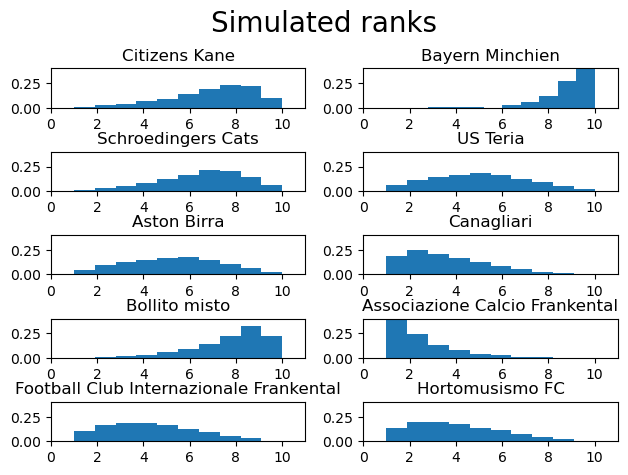

In [10]:
fig, ax = plt.subplots(5,2)
fig.tight_layout(rect=(0,0,1,0.9))
fig.suptitle("Simulated ranks", fontsize = 20)

for i,team in enumerate(teams):
    
    ax[i%5,i%2].set_title(team)
    ax[i%5,i%2].set_xlim(0,11)
    ax[i%5,i%2].set_ylim(0,0.4)    
    ax[i%5,i%2].hist(results[team], density=True, bins=10)
    